# Fraud detection

## Let's import some packages to make things easier for us.

In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import time
import sqlite3
import sklearn.tree
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb

## Loading in the relevant data sources

In [2]:
fraudData = pd.read_csv('Fraud_Data.csv')
Ips = pd.read_csv('IpAddress_to_Country.csv')

## Let's take a cursory look at these.

In [3]:
fraudData.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
Ips.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Initial observations
- I notice that on the only fraud case displayed there is only a 1 second delay between signup and use time.
- I also notice that the operating system is Opera which is not a particularly well used internet service.


## Having noticed that there is only a 1 second delay between signup and use on one of the frauds perhaps a column of the differences between the two could be useful.

In [5]:
def timeToNum(x):
    return time.mktime(time.strptime(x,'%Y-%m-%d %H:%M:%S'))

In [6]:
signup = fraudData['signup_time'].copy()
purchase = fraudData['purchase_time'].copy()
sign = signup.apply(timeToNum)
pur = purchase.apply(timeToNum)
Diff = pur - sign

## Let's see what that did for us. The following checks how many 1 second differences there are in the data frame and then sees how many are fraudulent.

In [7]:
print(len(fraudData.iloc[np.where(Diff.values == 1)[0],:]))
print(np.sum(fraudData.iloc[np.where(Diff.values == 1)[0],:].values[:,-1]))

7600
7600


## A difference of 1 second between the two correctly identified 7600/14151 fraudulent cases even before I've made a model. A recall of 53.7%

## Let's append the new column to our DF.

In [8]:
fraudData = fraudData.assign(Difference=pd.Series(Diff))

In [9]:
fraudData.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,Difference
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4503082.0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944.0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1.0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085.0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461.0


## Let's see what we can expect our models to look at.

In [10]:
frauds = fraudData.iloc[np.where(fraudData['class'] == 1)[0],]
notfrauds = fraudData.iloc[np.where(fraudData['class'] == 0)[0],]

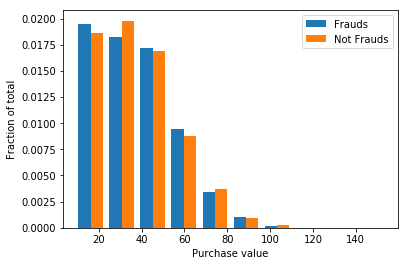

In [11]:
plt.hist([frauds['purchase_value'], notfrauds['purchase_value']], density = True,label = ['Frauds','Not Frauds'])
plt.xlabel('Purchase value')
plt.ylabel('Fraction of total')
plt.legend()

### What to note from the previous graph is that most of the purchase values are about evenly represented between frauds and not frauds. The biggest difference is in the 25-30 range.

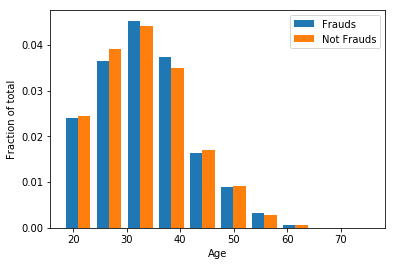

In [12]:
plt.hist([frauds['age'], notfrauds['age']], density = True,label = ['Frauds','Not Frauds'])
plt.xlabel('Age')
plt.ylabel('Fraction of total')
plt.legend()

### Once again similar ratios between fraudulent and non-fraudulent.

Text(0,0.5,'Fraud or not')

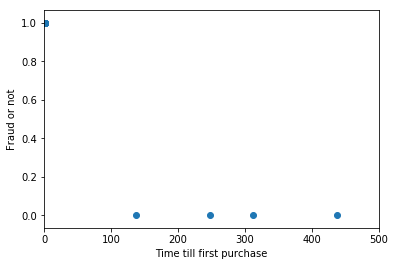

In [13]:
plt.scatter(fraudData['Difference'], fraudData['class'])
plt.xlim(0,500)
plt.xlabel('Time till first purchase')
plt.ylabel('Fraud or not')

### The above graph tells us what we already knew in that fraudulent transactions have a way smaller lower bound than non-fraudulent ones.

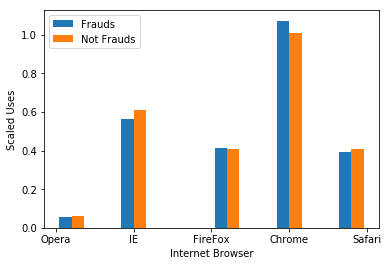

In [14]:
plt.hist([frauds['browser'], notfrauds['browser']], density = True,label = ['Frauds','Not Frauds'])
plt.xlabel('Internet Browser')
plt.ylabel('Scaled Uses')
plt.legend()

### We can see from the above graph that near equal percentages of fraudulent and non-fraudulent transactions occur on each browser.

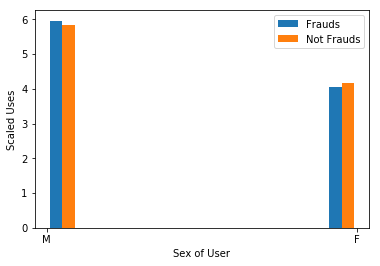

In [15]:
plt.hist([frauds['sex'], notfrauds['sex']], density = True,label = ['Frauds','Not Frauds'])
plt.xlabel('Sex of User')
plt.ylabel('Scaled Uses')
plt.legend()

### Near equal fractions of fraud and non-fraudulent transactions by sex.

## One-Hot-Encoding the Browsers

In [16]:
fraudBrowser = pd.get_dummies(fraudData, columns = ['browser'])

In [17]:
fraudBrowser.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,sex,age,ip_address,class,Difference,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,M,39,7.327584e+08,0,4503082.0,1,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,F,53,3.503114e+08,0,17944.0,1,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,M,53,2.621474e+09,1,1.0,0,0,0,1,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,M,41,3.840542e+09,0,492085.0,0,0,0,0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,M,45,4.155831e+08,0,4361461.0,0,0,0,0,1


## Having dealt with the things I noticed let's move on to trading out IP address's for something slightly more useful.

In [18]:
ips = Ips.values

In [19]:
conn = sqlite3.connect('temp.db')

In [20]:
cur = conn.cursor()

In [21]:
fraudBrowser.to_sql('fraud', conn, if_exists = 'replace')

## So there is a slight problem with the IP table in that some of the ip addresses in the transactions are lower and higher than any country in the ips data set so I need to add a row to the ips to make sure that the implicit join will have the same number of rows as the fraud table.

In [22]:
minip = np.min(Ips.values[:,0])
maxip = np.max(Ips.values[:,1])
Ips.loc[len(Ips)] = [0,int(minip - 1), 'None']
Ips.loc[len(Ips)] = [int(maxip+1),1e12, 'None']

In [23]:
Ips.to_sql('ips', conn, if_exists = 'replace')

In [24]:
Country = pd.read_sql_query('select fraud.*, ips.country from fraud, ips where fraud.ip_address >= ips.lower_bound_ip_address AND fraud.ip_address <= ips.upper_bound_ip_address', conn)

In [25]:
conn.close()

In [26]:
Country.head()

,index,user_id,signup_time,purchase_time,purchase_value,device_id,source,sex,age,ip_address,class,Difference,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,country
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,M,39,7.327584e+08,0,4503082.0,1,0,0,0,0,Japan
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,F,53,3.503114e+08,0,17944.0,1,0,0,0,0,United States
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,M,53,2.621474e+09,1,1.0,0,0,0,1,0,United States
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,M,41,3.840542e+09,0,492085.0,0,0,0,0,1,None
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,M,45,4.155831e+08,0,4361461.0,0,0,0,0,1,United States


## Even with adding IP addresses to both ends of the spectrum yields some lost rows, so I'm going to slightly more manually assign those rows a country None

In [27]:
colist = Country['index'].values
frlist = list(fraudBrowser.index.values)
notlist = list(set(frlist).difference(colist))

In [28]:
notCountry = fraudBrowser.iloc[notlist,:]

In [29]:
notCountry.loc[:,'country'] = 'None'

/home/donald/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/donald/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [30]:
newCount = Country.copy().drop(['index'], axis=1)

In [31]:
afterCountry = newCount.append(notCountry)

In [32]:
afterCountry.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,sex,age,ip_address,class,Difference,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,M,39,7.327584e+08,0,4503082.0,1,0,0,0,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,F,53,3.503114e+08,0,17944.0,1,0,0,0,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,M,53,2.621474e+09,1,1.0,0,0,0,1,0,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,M,41,3.840542e+09,0,492085.0,0,0,0,0,1,None
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,M,45,4.155831e+08,0,4361461.0,0,0,0,0,1,United States


## Now that we've dealt with assigning Countries to every user let's turn some things into numbers that we can model with. First and foremost source, sex, and the newly defined Country.

In [33]:
afterSource = pd.get_dummies(afterCountry, columns = ['source','sex','country'])

In [34]:
afterSource.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,Difference,browser_Chrome,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,7.327584e+08,0,4503082.0,1,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,17944.0,1,...,1,0,0,0,0,0,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,1.0,0,...,1,0,0,0,0,0,0,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3.840542e+09,0,492085.0,0,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,4.155831e+08,0,4361461.0,0,...,1,0,0,0,0,0,0,0,0,0


## So there is a practical aspect to consider here. If I leave in all of these columns it is possible that we will discriminate against a certain country unfairly. If we have one observation of that country and it happens to be fraudulent than the model could learn that and automatically classify any transaction from that country as fraudulent. To eliminate this possibility the following drops any country columns that have less than 50 observations.

In [35]:
names = list(afterSource)[19:]

In [36]:
smalls = []
for name in names:
    if np.sum(afterSource[name].values) < 50:
        smalls.append(name)
lessCount = afterSource.drop(smalls, axis=1)

In [37]:
lessCount.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,Difference,browser_Chrome,...,country_Thailand,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Viet Nam
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,7.327584e+08,0,4503082.0,1,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,17944.0,1,...,0,0,0,0,0,0,1,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,1.0,0,...,0,0,0,0,0,0,1,0,0,0
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3.840542e+09,0,492085.0,0,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,4.155831e+08,0,4361461.0,0,...,0,0,0,0,0,0,1,0,0,0


## We are almost to actual modeling, so let's quickly make sure the model can see what we did with the 1 second difference and make an indicator column for that.

In [38]:
isOneSecond = np.array(lessCount['Difference'].values == 1, dtype = int).tolist()
lessCount['isOne'] = isOneSecond

In [39]:
lessCount.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,Difference,browser_Chrome,...,country_Tunisia,country_Turkey,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Venezuela,country_Viet Nam,isOne
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,39,7.327584e+08,0,4503082.0,1,...,0,0,0,0,0,0,0,0,0,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,17944.0,1,...,0,0,0,0,0,1,0,0,0,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,1.0,0,...,0,0,0,0,0,1,0,0,0,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,41,3.840542e+09,0,492085.0,0,...,0,0,0,0,0,0,0,0,0,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,45,4.155831e+08,0,4361461.0,0,...,0,0,0,0,0,1,0,0,0,0


## Now let's see what we can do with an actual model and the numerical values in our data frame.

In [40]:
shuffled = lessCount.sample(frac=1, random_state=726366).reset_index(drop=True).drop(['user_id','signup_time','purchase_time','ip_address','device_id'], axis=1)

In [41]:
Y = shuffled['class'].values.reshape(-1,1)
X = shuffled.drop(['class'], axis = 1).values

In [42]:
Xtrain = X[0:int(np.round(.7*len(X))),]
Xval = X[int(np.round(.7*len(X))):int(np.round(.85*len(X))),]
Xtest = X[int(np.round(.85*len(X))):,]
Ytrain = Y[0:int(np.round(.7*len(Y))),]
Yval = Y[int(np.round(.7*len(Y))):int(np.round(.85*len(Y))),]
Ytest = Y[int(np.round(.85*len(Y))):,]
mins = np.min(Xtrain, axis = 0)
maxs = np.max(Xtrain, axis = 0)
Xtrain = (Xtrain - mins)/(maxs - mins)
Xval = (Xval - mins)/(maxs - mins)
Xtest = (Xtest - mins)/(maxs - mins)

## One of the main problems you need to deal with in fraud detection is the imbalanced class problem. The imbalanced class problem makes your models predict all majority class. To address this let's do some over and undersampling.

In [43]:
ones = Xtrain[np.where(Ytrain == 1)[0],]
Yones = Ytrain[np.where(Ytrain == 1)[0],]
zeros = Xtrain[np.where(Ytrain == 0)[0],]
Yzeros = Ytrain[np.where(Ytrain == 0)[0],]

In [44]:
oversampledones = ones[np.random.choice(range(len(ones)), 15000, replace=True),]
undersampledzeros = zeros[np.random.choice(range(len(zeros)), 15000, replace=True),]

In [45]:
overs = np.column_stack((oversampledones,np.ones((len(oversampledones),1))))
unders = np.column_stack((undersampledzeros, np.zeros((len(undersampledzeros),1))))

In [46]:
full = np.row_stack((overs,unders))
xs = full[:,:-1]
ys = full[:,-1]

In [47]:
for i in range(1,40):
    streemodel = sklearn.tree.DecisionTreeClassifier(max_depth = i).fit(xs,ys)
    print('Max Depth: '+str(i)+' '+str(roc_auc_score(Yval, streemodel.predict_proba(Xval)[:,1])))

Max Depth: 1 0.7760293478485739
Max Depth: 2 0.7875247545146244
Max Depth: 3 0.7871044777157649
Max Depth: 4 0.7876277430522713
Max Depth: 5 0.7877036180505661
Max Depth: 6 0.783648252406476
Max Depth: 7 0.7842069313454016
Max Depth: 8 0.7821626314583187
Max Depth: 9 0.7836634635424642
Max Depth: 10 0.7816468531174767
Max Depth: 11 0.7810227561304603
Max Depth: 12 0.7755609532691318
Max Depth: 13 0.7762068675647809
Max Depth: 14 0.771487542045748
Max Depth: 15 0.772969538068403
Max Depth: 16 0.7684610115660646
Max Depth: 17 0.7667201552091467
Max Depth: 18 0.7655686033299809
Max Depth: 19 0.7645336475748503
Max Depth: 20 0.7591320004087018
Max Depth: 21 0.7566243198578251
Max Depth: 22 0.755490824850556
Max Depth: 23 0.7517468753142166
Max Depth: 24 0.7525180358676554
Max Depth: 25 0.7508699821206477
Max Depth: 26 0.7527356330312426
Max Depth: 27 0.7488493854068675
Max Depth: 28 0.7522394699414853
Max Depth: 29 0.7475006195121903
Max Depth: 30 0.7462261137736057
Max Depth: 31 0.7410819

In [48]:
streemodel = sklearn.tree.DecisionTreeClassifier(max_depth = 4).fit(xs,ys)
predictions = streemodel.predict_proba(Xval)

## From a simple Decision Tree we can see that the following are the features that tell us the most about whether something is fraudulent or not. Note that Difference is indeed one of the most telling features.

In [49]:
np.array(list(shuffled.drop(['class'], axis = 1)))[np.where(streemodel.feature_importances_ >= 1e-04)[0]]

array(['purchase_value', 'age', 'Difference', 'source_Direct', 'sex_M',
       'country_Canada', 'country_China', 'country_Colombia', 'isOne'],
      dtype='<U39')

## Now let's break out the big guns.

In [50]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
for i in range(28,35):
    for j in range(1,9):
        RFclassifier = RandomForestClassifier(n_estimators=i, max_depth=3,min_samples_leaf=j, random_state = 726366).fit(Xtrain,Ytrain.T.tolist()[0])
        print(str(i)+ ' trees '+str(j)+' examples '+str(roc_auc_score(Yval, RFclassifier.predict_proba(Xval)[:,1])))

28 trees 1 examples 0.792468689903591
28 trees 2 examples 0.792468689903591
28 trees 3 examples 0.7924687802444135
28 trees 4 examples 0.7924503507166241
28 trees 5 examples 0.7924504410574466
28 trees 6 examples 0.7924504410574466
28 trees 7 examples 0.7924069419514141
28 trees 8 examples 0.7922835589730888
29 trees 1 examples 0.7924716711507334
29 trees 2 examples 0.7924716711507334
29 trees 3 examples 0.7924717614915558
29 trees 4 examples 0.7924546193204871
29 trees 5 examples 0.7924547096613095
29 trees 6 examples 0.7924547096613095
29 trees 7 examples 0.7924311081214321
29 trees 8 examples 0.7923145684604108
30 trees 1 examples 0.7924097876873228
30 trees 2 examples 0.7924097876873228
30 trees 3 examples 0.7924098780281452
30 trees 4 examples 0.7924213400199995
30 trees 5 examples 0.7924214303608221
30 trees 6 examples 0.7924214303608221
30 trees 7 examples 0.7923569044283534
30 trees 8 examples 0.7922435492813251
31 trees 1 examples 0.7924293577679963
31 trees 2 examples 0.79242

## A random forest of 32 trees and 6 or more examples per leaf seems to be the best it can do. It slightly beat the decision tree.

In [52]:
RFclassifier = RandomForestClassifier(n_estimators=32, max_depth=3,min_samples_leaf=6, random_state = 726366).fit(Xtrain,Ytrain.T.tolist()[0])
predictions = RFclassifier.predict_proba(Xval)
np.array(list(shuffled.drop(['class'], axis = 1)))[np.where(RFclassifier.feature_importances_ >= 1e-04)[0]]

array(['purchase_value', 'age', 'Difference', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Safari', 'source_Ads',
       'source_Direct', 'source_SEO', 'sex_F', 'sex_M', 'country_Belgium',
       'country_Bolivia', 'country_Canada', 'country_Chile',
       'country_China', 'country_Denmark', 'country_Ecuador',
       'country_Germany', 'country_Ireland', 'country_Israel',
       'country_Kazakhstan', 'country_Kuwait', 'country_Luxembourg',
       'country_Mexico', 'country_Netherlands', 'country_New Zealand',
       'country_Peru', 'country_Poland', 'country_Saudi Arabia',
       'country_Seychelles', 'country_Tunisia', 'country_Ukraine',
       'country_United Kingdom', 'isOne'], dtype='<U39')

In [53]:
for i in range(2,7):
    dtrain = xgb.DMatrix(xs, label = ys)
    param = {'max_depth': i, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
    param['nthread'] = 4
    param['eval_metric'] = 'auc'
    dval = xgb.DMatrix(Xval, label = Yval)
    evallist = [(dtrain,'train'),(dval,'eval')]
    num_round = 8
    xgmodel = xgb.train(param, dtrain, num_round, evallist)

/home/donald/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[0]	train-auc:0.777917	eval-auc:0.787511
[1]	train-auc:0.780343	eval-auc:0.787207
[2]	train-auc:0.780784	eval-auc:0.787874
[3]	train-auc:0.781272	eval-auc:0.787326
[4]	train-auc:0.781654	eval-auc:0.787489
[5]	train-auc:0.782177	eval-auc:0.78847
[6]	train-auc:0.782434	eval-auc:0.788234
[7]	train-auc:0.783374	eval-auc:0.788234
[0]	train-auc:0.78135	eval-auc:0.787069
[1]	train-auc:0.782576	eval-auc:0.786059
[2]	train-auc:0.783273	eval-auc:0.785992
[3]	train-auc:0.784078	eval-auc:0.786864
[4]	train-auc:0.785055	eval-auc:0.786868
[5]	train-auc:0.786645	eval-auc:0.787544
[6]	train-auc:0.787128	eval-auc:0.787637
[7]	train-auc:0.792104	eval-auc:0.786554
[0]	train-auc:0.784316	eval-auc:0.787628
[1]	train-auc:0.786719	eval-auc:0.788583
[2]	train-auc:0.788555	eval-auc:0.788063
[3]	train-auc:0.790394	eval-auc:0.788275
[4]	train-auc:0.793712	eval-auc:0.786736
[5]	train-auc:0.7961	eval-auc:0.786169
[6]	train-auc:0.797602	eval-auc:0.785376
[7]	train-auc:0.802267	eval-auc:0.785866
[0]	train-auc:0.7883

## Notice that we didn't beat the Random Forest.

In [54]:
dtrain = xgb.DMatrix(xs, label = ys)
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
dval = xgb.DMatrix(Xval, label = Yval)
evallist = [(dtrain,'train'),(dval,'eval')]
num_round = 2
xgmodel = xgb.train(param, dtrain, num_round, evallist)

[0]	train-auc:0.777917	eval-auc:0.787511
[1]	train-auc:0.780343	eval-auc:0.787207


In [55]:
fpr, tpr, thresh = roc_curve(Ytest,RFclassifier.predict_proba(Xtest)[:,1],drop_intermediate = False)

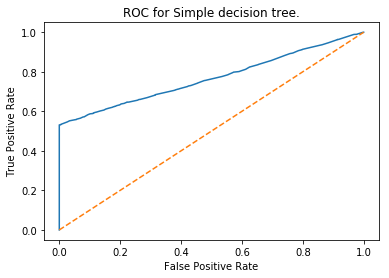

In [56]:
plt.plot(fpr,tpr)
plt.title('ROC for Simple decision tree.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], linestyle='--')

## Finally we must address what to do if we were going to production with a model similar to this. Since we are particularly interested in detecting as many frauds as we can, it would be to our benefit if we adjusted the threshold at which we determine whether a transaction is fraud downward or perhaps made a scale of thresholds. Something like 'If the model reports a probability of .4-.7 pause the transaction and make the customer do something to prove that they are not fraudulent, like signing in with another service. If the probability is less than .4 let them proceed as normal. If the probability is greater than .7 stop the transaction entirely.'